# Various Types of Finite Difference Advection Algorithms

The advection equation gives the flow of any quantity (mass, density, charge etc) on a velocity field. Advection equation in fluid dynamics can be represented by the following equation

$$\frac{d\rho}{dt}=-\nabla(\rho V)$$

where $\rho$ is the density, V is the velocity field. 
In one dimension the above equation can be written as,
$$\frac{d\rho}{dt}=-\frac{d(\rho V)}{dx}$$

### Central finite difference form

The above equation can be written in central finite difference form as
$$\frac{\rho_i^{t+1}-\rho_i^{t}}{dt}=\frac{\rho_{i+1}V_{i+1}-\rho_{i-1}V_{i-1}}{dx}$$

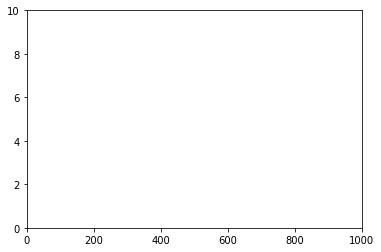

In [6]:
## Code to generate GIF image <source = "http://tiao.io/posts/notebooks/save-matplotlib-animations-as-gifs/">
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots();


ax.set_xlim(( 0, 1000));
ax.set_ylim((-0, 10));
line, = ax.plot([], [], lw=2);

def sett(x1,x2,y1,y2):
    ax.set_xlim(( x1,x2));
    ax.set_ylim((y1, y2));
    line, = ax.plot([], [], lw=2);

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i,rho,xx,step):
    x = xx
    rr=step*i
    y = rho[rr]
    sett(xx.min(),xx.max(),rho[rr].min(),rho[rr].max())
    line.set_data(x, y)
    return (line,)

In [7]:
spacegrid=1000
width=1.0
xx=np.arange(spacegrid)
timesteps=1000
simulationtime=1.0
velocity=1.0
dt=simulationtime/timesteps
dx=width/spacegrid
rho=np.zeros((timesteps,spacegrid),float)
rho[0,30:300]=10
veolcitygrid=velocity*np.ones(spacegrid)

for t in range(timesteps-1):
    #Explicit----------------------------------------------------------------------------------------
    rho[t+1,1:spacegrid-1]=rho[t,1:spacegrid-1]-dt*velocity*(rho[t,2:spacegrid]-rho[t,0:spacegrid-2])/(2*dx)
    #plt.plot(rho[t])
    #plt.show()
    #sett(0,1000,0,20)

anim = animation.FuncAnimation(fig, animate, fargs=(rho,xx,10,), init_func=init,frames=100, interval=200, blit=True)
HTML(anim.to_html5_video())

## Effect of time-stepping (Increased accuracy but decreased speed)
Let us not decrease the time step 'dt' and execute the code again. Decreasing the time stepping makes the program very slow but makes the simulation result better.

In [8]:
spacegrid=1000
width=1.0
xx=np.arange(spacegrid)
timesteps=10000
simulationtime=1.0
velocity=1.0
dt=simulationtime/timesteps
dx=width/spacegrid
rho=np.zeros((timesteps,spacegrid),float)
rho[0,30:300]=10
veolcitygrid=velocity*np.ones(spacegrid)

for t in range(timesteps-1):
    #Explicit----------------------------------------------------------------------------------------
    rho[t+1,1:spacegrid-1]=rho[t,1:spacegrid-1]-dt*velocity*(rho[t,2:spacegrid]-rho[t,0:spacegrid-2])/(2*dx)
    #plt.plot(rho[t])
    #plt.show()
    #sett(0,1000,0,20)

anim = animation.FuncAnimation(fig, animate, fargs=(rho,xx,100,), init_func=init,frames=100, interval=200, blit=True)
HTML(anim.to_html5_video())

## Implicit Finite difference form
The above continuity equation can be written in implicit finite difference form by taking the future time step in the following manner.

$$

In [ ]:
Code

Upwind Algorithm

In [ ]:
code

area code

result discussion

In [ ]:
# Paste your code here
#
#
%matplotlib inline
import math,os,sys,numpy as np
from numpy.random import random
from matplotlib import pyplot as plt, rcParams, animation, rc
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed 
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3,3
%precision 4
np.set_printoptions(precision=4, linewidth=100)

def lin(a,x,b): return a * x + b

a = 3.
b = 8.
n = 30

x = random(n)
y = lin(a,x,b)

plt.scatter(x,y)

def sse(y, y_pred): return ((y-y_pred)**2).sum()
def loss(y, a, x, b): return sse(y, lin(a, x, b))
def avg_loss(y, a, x, b): return np.sqrt(loss(y, a, x, b)/n)

a_guess = -1
b_guess = 1
avg_loss(y, a_guess, x, b_guess)

lr = 0.01
#d[(y-(a*x+b))**2, b] = 2 (y_pred - y)
#d[(y -(a*x+b)) **2, a] = x * dy/db

def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, x, b_guess)
    dydb = 2 * (y_pred - y)
    dyda = x * dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()


fig = plt.figure(dpi=100, figsize=(5,5))
plt.scatter(x,y)
line, = plt.plot(x, lin(a_guess, x, b_guess))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess, x, b_guess))
    for i in range(10): upd()
    return line,


ani = animation.FuncAnimation(fig, animate, np.arange(0, 40), interval=100)
ani